In [1]:
import os
import time
import folium
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from turtle import color
from folium import plugins
import matplotlib.pyplot as plt
%matplotlib inline
from folium.plugins import FastMarkerCluster
pd.options.mode.chained_assignment = None  #close copy warning   

In [2]:
property_df = pd.read_csv("../data/curated/data.csv")

In [3]:
print(list(property_df.columns))

['address', 'rent_weekly', 'floor', 'suburb', 'postcode', 'type', 'furnitured', 'pool', 'gym', 'num_bed', 'num_bath', 'num_car_park', 'coordinates', 'SECONDARY SCHOOL', 'PRIMARY AND SECONDARY SCHOOL', 'PRIMARY SCHOOL', 'SHOPPING CENTRE', 'PARK', 'KINDERGARTEN', 'POST OFFICE', 'SPECIAL SCHOOL', 'CHILD CARE', 'BAR', 'SPORTS COMPLEX', 'EDUCATION COMPLEX', 'CEMETERY', 'LIBRARY', 'UNIVERSITY', 'GENERAL HOSPITAL', 'POLICE STATION', 'FURTHER EDUCATION', 'PLAYGROUND', 'PLANTATION', 'WINERY', 'FARM', 'VINEYARD', 'TENNIS COURT', 'BAY', 'PIER', 'SWIMMING POOL', 'ART GALLERY', 'HARBOUR', 'COMMUNITY HEALTH CENTRE', 'MARKET', 'PRISON', 'BOTANIC GARDENS', 'SPECIALISED HOSPITAL', 'BANK', 'AGED CARE', 'SURFING SPOT', 'COAST', 'GOLF COURSE', 'HELIPORT', 'AIRPORT', 'IRON ORE PROCESSOR', 'MILL/TIMBER OPERATIONS', 'BEACH', 'TRAIN STATION', 'TRAM STATION', 'BUS', 'Education', 'Commercial', 'Environment', 'Medication', 'Secrity', 'Industrial', 'Prison', 'Transportation', 'cloest_train_station', 'cloest_SECON

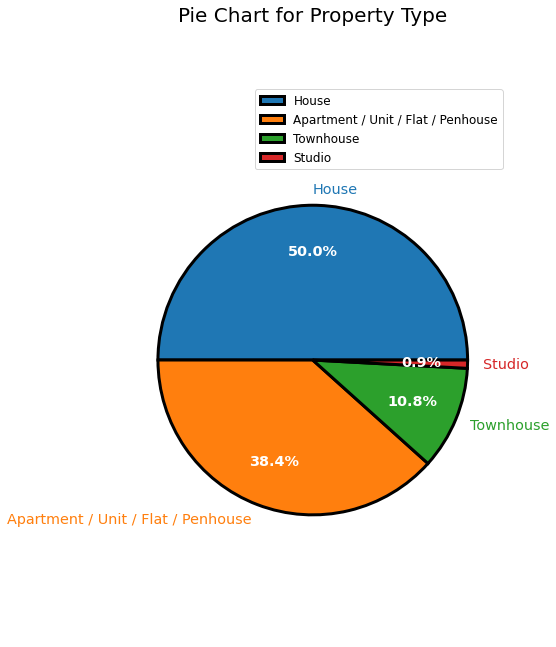

In [4]:
pie_data = property_df['type'].value_counts()
labels = pie_data.index
sizes = pie_data.values
#get label and size
fig, ax = plt.subplots(figsize = (10,9))
#draw the pie char and modify the pie chart
patches, texts, pcts = ax.pie(pie_data ,explode=None,autopct='%1.1f%%',
                               pctdistance = 0.7, labels=labels,wedgeprops={'linewidth': 3.0, 'edgecolor': 'black'},
                               textprops={'size': 'x-large'})

plt.setp(pcts, color='white', fontweight='bold')  #label color
# face color.
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
plt.legend(labels,prop={'size': 12},bbox_to_anchor=(1.0, 1.0))
plt.title("Pie Chart for Property Type", x=0.5, y=1.1,fontsize=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

fig.figure.savefig('../plots/type_pie.png')

In [5]:
property_df['counts'] = 1

In [6]:
count_number = property_df.groupby('suburb').agg('count')[['counts']].reset_index()
count_number

,suburb,counts
0,ABBOTSFORD,40
1,ABERFELDIE,11
2,ADAMS ESTATE,6
3,ADDINGTON,4
4,ADELAIDE LEAD,1
...,...,...
565,YARRAGON,1
566,YARRAM,1
567,YARRAVILLE,65
568,YARRAWONGA,16


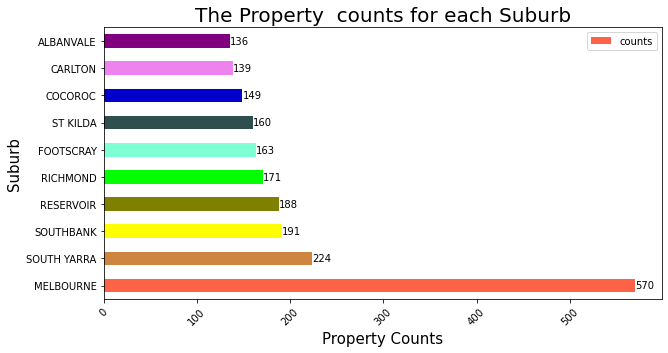

In [7]:
data = count_number.sort_values(by=['counts'], ascending=False).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="counts",figsize=(10,5),
                     color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine',
                            'darkslategray', 'mediumblue', 'violet', 'purple'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Property Counts", fontsize=15)
plt.title("The Property  counts for each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/property_count.png')

In [8]:
mean_suburb = property_df.groupby('suburb').agg('mean')[['rent_weekly']].reset_index()
mean_suburb

,suburb,rent_weekly
0,ABBOTSFORD,571.875000
1,ABERFELDIE,490.454545
2,ADAMS ESTATE,470.833333
3,ADDINGTON,388.750000
4,ADELAIDE LEAD,380.000000
...,...,...
565,YARRAGON,420.000000
566,YARRAM,585.000000
567,YARRAVILLE,437.907692
568,YARRAWONGA,386.562500


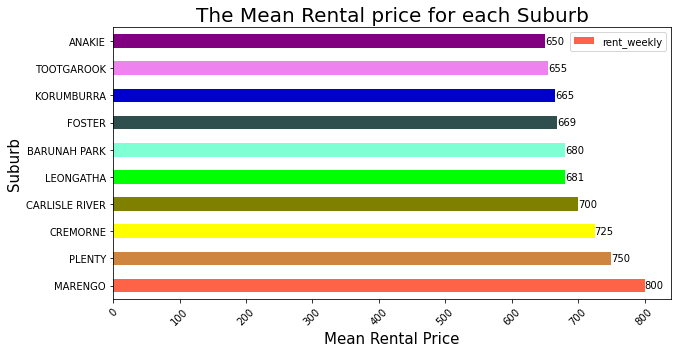

In [9]:
data = mean_suburb.sort_values(by=['rent_weekly'], ascending=False).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine', 'darkslategray',
                            'mediumblue', 'violet', 'purple'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price", fontsize=15)
plt.title("The Mean Rental price for each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/suburb_mean_desc.png')

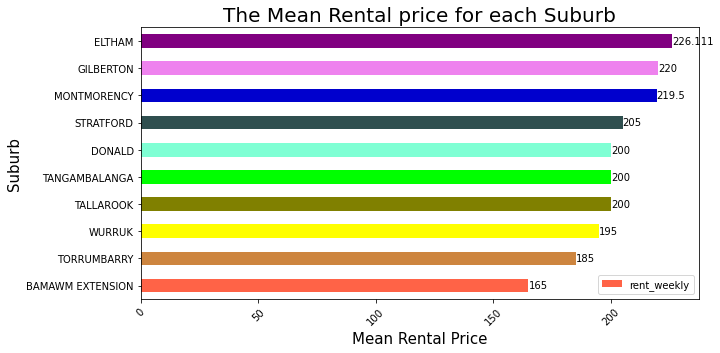

In [10]:
data = mean_suburb.sort_values(by=['rent_weekly'], ascending=True).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine', 'darkslategray',
                            'mediumblue', 'violet', 'purple'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price", fontsize=15)
plt.title("The Mean Rental price for each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/suburb_mean_asce.png')

In [11]:
property_df['type']= property_df['type'].replace('Townhouse','House')

In [12]:
apa = property_df[property_df['type'] == 'Apartment / Unit / Flat / Penhouse']
house = property_df[property_df['type'] == 'House']

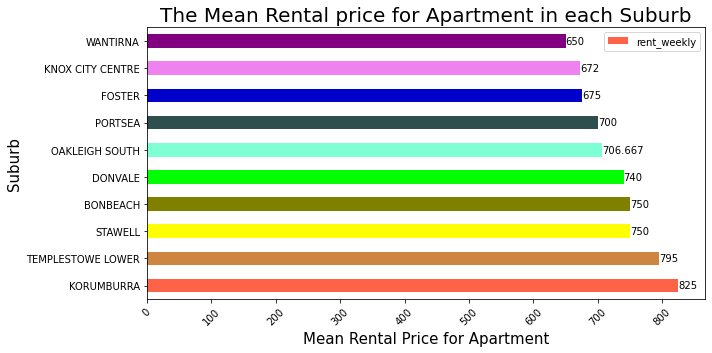

In [13]:
mean_suburb = apa.groupby('suburb').agg('mean')[['rent_weekly']].reset_index()
data = mean_suburb.sort_values(by=['rent_weekly'], ascending=False).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine', 'darkslategray',
                            'mediumblue', 'violet', 'purple'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price for Apartment", fontsize=15)
plt.title("The Mean Rental price for Apartment in each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/apa_suburb_mean_desc.png')

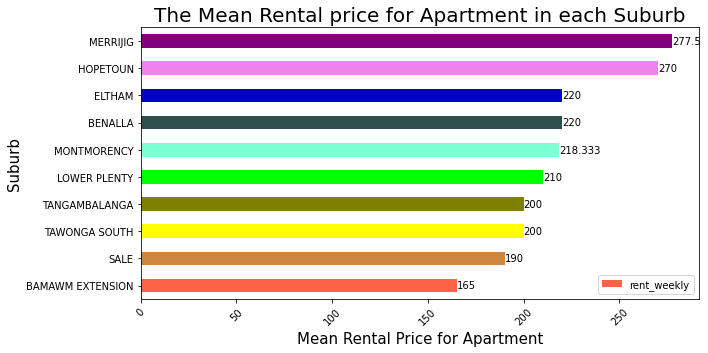

In [14]:
mean_suburb = apa.groupby('suburb').agg('mean')[['rent_weekly']].reset_index()
data = mean_suburb.sort_values(by=['rent_weekly'], ascending=True).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine', 'darkslategray',
                            'mediumblue', 'violet', 'purple'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price for Apartment", fontsize=15)
plt.title("The Mean Rental price for Apartment in each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/apa_suburb_mean_asce.png')

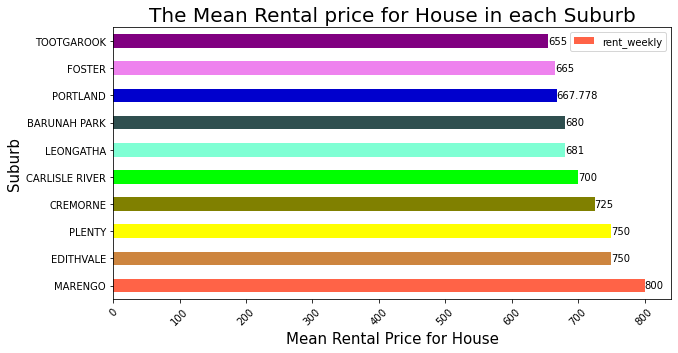

In [15]:
mean_suburb = house.groupby('suburb').agg('mean')[['rent_weekly']].reset_index()
data = mean_suburb.sort_values(by=['rent_weekly'], ascending=False).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine', 'darkslategray',
                            'mediumblue', 'violet', 'purple'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price for House", fontsize=15)
plt.title("The Mean Rental price for House in each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/house_suburb_mean_desc.png')

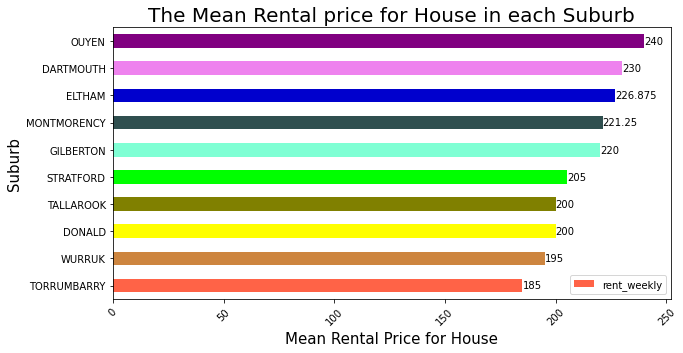

In [16]:
mean_suburb = house.groupby('suburb').agg('mean')[['rent_weekly']].reset_index()
data = mean_suburb.sort_values(by=['rent_weekly'], ascending=True).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine', 'darkslategray',
                            'mediumblue', 'violet', 'purple'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price for House", fontsize=15)
plt.title("The Mean Rental price for House in each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/house_suburb_mean_asce.png')

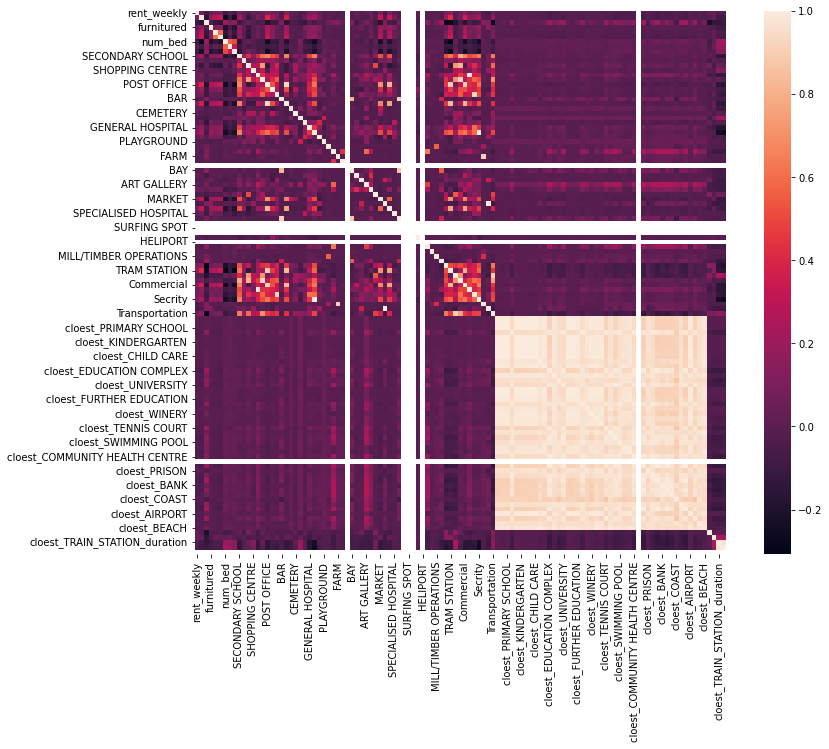

In [17]:
# Pearson correlation
fig, ax = plt.subplots(figsize = (12,10))
fig = sns.heatmap(property_df.corr())
fig.figure.savefig('../plots/heatmap.png',bbox_inches = 'tight')

In [18]:
property_df.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False).head(20)

,rent_weekly
rent_weekly,1.000000
TRAM STATION,0.174567
Commercial,0.156781
POST OFFICE,0.147616
SPORTS COMPLEX,0.133844
MARKET,0.123225
Secrity,0.117222
POLICE STATION,0.117222
TRAIN STATION,0.113993
gym,0.109401


## Young Adulthood

In [29]:
property_df['livable'] = property_df['Commercial']*0.3 + property_df['UNIVERSITY']*0.3 + property_df['TRAIN STATION']*0.05 + property_df['BUS']*0.05+ property_df['TRAM STATION']*0.1+ property_df['Secrity']*0.05 + property_df['Medication']*0.05 + property_df['Environment']*0.1
property_df = property_df.sort_values(by=['livable'], ascending=False)
property_df.head(10)

,address,rent_weekly,floor,suburb,postcode,type,furnitured,pool,gym,num_bed,...,cloest_IRON ORE PROCESSOR,cloest_MILL/TIMBER OPERATIONS,cloest_BEACH,cloest_TRAM STATION,cloest_BUS,cloest_TRAIN_STATION,cloest_TRAIN_STATION_duration,cloest_TRAIN_STATION_distance,counts,livable
228,504/639 Lonsdale Street Melbourne VIC 3000,580,5,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,1,1,2,...,58415.659533,64517.301961,4359.614389,94.344373,120.262077,Flagstaff Railway Station (Melbourne City),128.8,861.1,1,22.3
55,1609/228 La Trobe Street Melbourne VIC 3000,380,16,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,1,0,0,2,...,59417.027970,63718.352026,5359.952266,75.647445,247.889509,Melbourne Central Railway Station (Melbourne C...,73.9,547.8,1,22.3
2,911/408 Lonsdale Street Melbourne VIC 3000,330,9,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,1,...,59069.898510,64077.037494,5011.485174,205.391048,21.831936,Melbourne Central Railway Station (Melbourne C...,69.9,515.3,1,22.3
70,5209/560 Lonsdale Street Melbourne VIC 3000,340,52,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,2,...,58638.646338,64350.835079,4581.766611,203.803971,30.682983,Flagstaff Railway Station (Melbourne City),59.9,433.3,1,22.3
294,803/199 William Street Melbourne VIC 3000,530,8,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,1,1,1,2,...,58717.155996,64367.371672,4658.758529,123.264461,79.301173,Flagstaff Railway Station (Melbourne City),76.0,460.1,1,22.3
355,110/133 Bourke Street Melbourne VIC 3000,480,1,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,1,0,0,1,...,59689.533356,63863.018860,5650.154216,22.400167,247.030434,Parliament Railway Station (Melbourne City),89.9,621.6,1,22.3
303,1707/620 Collins St Melbourne VIC 3000,545,17,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,1,0,0,2,...,58225.695485,64894.342186,4173.306916,23.381216,90.346921,Flagstaff Railway Station (Melbourne City),160.5,1190.5,1,22.3
305,2101/200 Spencer St Melbourne VIC 3000,430,21,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,1,0,0,2,...,58325.614888,64644.751415,4267.537986,95.227987,187.165648,Flagstaff Railway Station (Melbourne City),138.7,1052.8,1,22.3
61,216/300 Swanston Street Melbourne VIC 3000,400,2,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,1,...,59495.760376,63761.178997,5437.596309,36.846771,96.774471,Melbourne Central Railway Station (Melbourne C...,155.2,998.8,1,22.3
8,1605/565 Flinders Street Melbourne VIC 3000,500,16,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,2,...,58185.942889,65091.372257,4156.961515,25.424122,285.540656,Southern Cross Railway Station (Melbourne City),143.7,931.9,1,22.3


In [30]:
livable = property_df[['suburb','livable','UNIVERSITY', 'Commercial', 'Environment', 'Medication',
                       'Secrity', 'Transportation','BUS','TRAM STATION','TRAIN STATION']]
livable = livable.drop_duplicates()
livable = livable.reset_index(drop = True)
livable.to_csv('../data/curated/livable_youth.csv',index=False)
livable.head(20)

,suburb,livable,UNIVERSITY,Commercial,Environment,Medication,Secrity,Transportation,BUS,TRAM STATION,TRAIN STATION
0,MELBOURNE,22.30,0.0,14.0,23.0,3.0,2.0,184.0,54.0,127.0,3.0
1,RESERVOIR,17.75,0.0,1.0,9.0,2.0,1.0,317.0,302.0,11.0,4.0
2,FRANKSTON,14.40,0.0,3.0,24.0,4.0,1.0,217.0,215.0,0.0,2.0
3,PRESTON,14.20,0.0,4.0,4.0,3.0,2.0,207.0,165.0,40.0,2.0
4,WERRIBEE,14.10,1.0,1.0,18.0,4.0,1.0,229.0,227.0,0.0,2.0
5,CAMBERWELL,13.65,0.0,2.0,14.0,5.0,1.0,145.0,58.0,82.0,5.0
6,SUNBURY,13.50,0.0,2.0,14.0,1.0,1.0,228.0,227.0,0.0,1.0
7,BERWICK,13.10,0.0,2.0,18.0,3.0,1.0,210.0,209.0,0.0,1.0
8,MORNINGTON,12.20,0.0,2.0,62.0,1.0,1.0,106.0,106.0,0.0,0.0
9,COBURG,12.00,0.0,2.0,22.0,4.0,1.0,143.0,105.0,36.0,2.0


## Middle Adulthood

In [31]:
property_df['livable'] = property_df['Commercial']*0.15 + property_df['BUS']*0.05 + property_df['TRAIN STATION']*0.1+ property_df['TRAM STATION']*0.05+ property_df['Secrity']*0.1 + property_df['Medication']*0.15 + property_df['Environment']*0.15 + property_df['Education']*0.3 - property_df['Prison']*0.2 - property_df['Industrial']*0.1
property_df = property_df.sort_values(by=['livable'], ascending=False)
property_df.head(10)

,address,rent_weekly,floor,suburb,postcode,type,furnitured,pool,gym,num_bed,...,cloest_IRON ORE PROCESSOR,cloest_MILL/TIMBER OPERATIONS,cloest_BEACH,cloest_TRAM STATION,cloest_BUS,cloest_TRAIN_STATION,cloest_TRAIN_STATION_duration,cloest_TRAIN_STATION_distance,counts,livable
5218,5/30 Ashley Street Reservoir VIC 3073,360,5,RESERVOIR,3073,Apartment / Unit / Flat / Penhouse,0,0,0,2,...,68754.633931,52858.550369,15671.029283,1648.957627,159.684606,Reservoir Railway Station (Reservoir),208.7,1179.1,1,27.85
5170,1035 High Street Reservoir VIC 3073,625,1,RESERVOIR,3073,House,0,0,0,3,...,70427.572300,50987.228487,17525.040063,-1.000000,335.821707,Keon Park Railway Station (Thomastown),89.9,796.2,1,27.85
5169,59A Rathcown Road Reservoir VIC 3073,450,1,RESERVOIR,3073,House,0,0,0,3,...,70963.642061,51527.778706,17539.227871,1294.760118,313.447213,Reservoir Railway Station (Reservoir),413.2,3316.9,1,27.85
5205,11/949 High Street Reservoir VIC 3073,580,11,RESERVOIR,3073,House,0,0,0,2,...,69633.860513,51990.573545,16577.348325,2109.747434,148.127117,Reservoir Railway Station (Reservoir),174.0,1171.9,1,27.85
5149,2/3 Suffolk Street Reservoir VIC 3073,420,2,RESERVOIR,3073,Apartment / Unit / Flat / Penhouse,0,0,0,2,...,69924.551150,51738.834004,16857.092293,2163.729822,152.711401,Ruthven Railway Station (Reservoir),67.6,281.7,1,27.85
5144,3/64 Darebin Blvd Reservoir VIC 3073,330,3,RESERVOIR,3073,House,0,0,0,4,...,71357.027993,50879.416820,18059.931696,1876.929434,76.878547,Keon Park Railway Station (Thomastown),228.9,2341.1,1,27.85
5143,66 Purinuan Road Reservoir VIC 3073,560,1,RESERVOIR,3073,House,0,0,0,4,...,70916.322444,51399.575904,17564.466701,1585.504536,88.345704,Reservoir Railway Station (Reservoir),349.0,2889.3,1,27.85
5142,6/101 Rathcown Road Reservoir VIC 3073,470,6,RESERVOIR,3073,House,0,0,0,3,...,70578.730427,51585.492850,17280.803942,1634.579566,89.697496,Ruthven Railway Station (Reservoir),279.7,1269.1,1,27.85
5141,9 Inverness Street Reservoir VIC 3073,370,1,RESERVOIR,3073,House,0,0,0,3,...,71598.209159,50747.761976,18263.382968,1706.337631,140.732949,Keon Park Railway Station (Thomastown),247.0,2343.6,1,27.85
5174,15/15 Chenies Street Reservoir VIC 3073,300,15,RESERVOIR,3073,House,1,0,0,2,...,70894.721162,51605.290036,17463.707388,1250.275389,259.394685,Reservoir Railway Station (Reservoir),388.6,3165.4,1,27.85


In [32]:
livable = property_df[['suburb','livable','Education', 'Commercial', 'Environment', 'Medication',
       'Secrity', 'Industrial', 'Prison', 'Transportation','BUS','TRAM STATION','TRAIN STATION']]
livable = livable.drop_duplicates()
livable = livable.reset_index(drop = True)
livable.to_csv('../data/curated/livable_middle.csv',index=False)
livable.head(20)

,suburb,livable,Education,Commercial,Environment,Medication,Secrity,Industrial,Prison,Transportation,BUS,TRAM STATION,TRAIN STATION
0,RESERVOIR,27.85,33.0,1.0,9.0,2.0,1.0,0.0,0.0,317.0,302.0,11.0,4.0
1,FRANKSTON,26.50,36.0,3.0,24.0,4.0,1.0,0.0,0.0,217.0,215.0,0.0,2.0
2,BERWICK,23.70,32.0,2.0,18.0,3.0,1.0,0.0,0.0,210.0,209.0,0.0,1.0
3,WERRIBEE,23.20,27.0,1.0,18.0,4.0,1.0,0.0,0.0,229.0,227.0,0.0,2.0
4,PRESTON,22.20,33.0,4.0,4.0,3.0,2.0,0.0,0.0,207.0,165.0,40.0,2.0
5,MELBOURNE,21.55,20.0,14.0,23.0,3.0,2.0,0.0,0.0,184.0,54.0,127.0,3.0
6,SUNBURY,21.00,23.0,2.0,14.0,1.0,1.0,0.0,0.0,228.0,227.0,0.0,1.0
7,MORNINGTON,20.85,19.0,2.0,62.0,1.0,1.0,0.0,0.0,106.0,106.0,0.0,0.0
8,CROYDON,19.35,25.0,2.0,24.0,1.0,1.0,0.0,0.0,153.0,152.0,0.0,1.0
9,COBURG,18.45,23.0,2.0,22.0,4.0,1.0,0.0,0.0,143.0,105.0,36.0,2.0


## Late Adulthood

In [33]:
property_df['BUS']*0.05 + property_df['TRAIN STATION']*0.1+ property_df['TRAM STATION']*0.05

5218     16.05
5170     16.05
5169     16.05
5205     16.05
5149     16.05
         ...  
7926      0.00
7928      0.00
13067     0.00
7847      0.00
2665      0.00
Length: 13455, dtype: float64

In [34]:
#property_df['livable'] = property_df['Commercial']*0.1 + property_df['Transportation']*0.2 + property_df['Secrity']*0.1 + property_df['Medication']*0.3 + property_df['Environment']*0.3 - property_df['Prison']*0.2 - property_df['Industrial']*0.1
property_df['livable'] = property_df['Commercial']*0.1 + property_df['BUS']*0.05 + property_df['TRAIN STATION']*0.1+ property_df['TRAM STATION']*0.05 + property_df['Secrity']*0.1 + property_df['Medication']*0.3 + property_df['Environment']*0.3 - property_df['Prison']*0.2 - property_df['Industrial']*0.1
property_df = property_df.sort_values(by=['livable'], ascending=False)
property_df.head(10)

,address,rent_weekly,floor,suburb,postcode,type,furnitured,pool,gym,num_bed,...,cloest_IRON ORE PROCESSOR,cloest_MILL/TIMBER OPERATIONS,cloest_BEACH,cloest_TRAM STATION,cloest_BUS,cloest_TRAIN_STATION,cloest_TRAIN_STATION_duration,cloest_TRAIN_STATION_distance,counts,livable
13047,1/16 Kent Street Mornington VIC 3931,450,1,MORNINGTON,3931,House,0,0,0,3,...,54870.197380,74444.738841,1039.755633,-1.0,196.660039,-1,-1.0,-1.0,1,24.5
13041,6/7 Cranswick Court Mornington VIC 3931,400,6,MORNINGTON,3931,Apartment / Unit / Flat / Penhouse,0,0,0,2,...,56401.285994,74051.416762,2378.624646,-1.0,623.971753,-1,-1.0,-1.0,1,24.5
13040,2/7 Hargreaves Street Mornington VIC 3931,440,1,MORNINGTON,3931,House,0,0,0,3,...,53909.313004,75276.576928,280.448997,-1.0,87.563428,-1,-1.0,-1.0,1,24.5
13046,2/13 King Georges Ave Mornington VIC 3931,500,1,MORNINGTON,3931,House,0,0,0,2,...,53790.165583,75499.855101,498.775412,-1.0,152.804092,-1,-1.0,-1.0,1,24.5
13045,3/38 Amelia Ave Mornington VIC 3931,450,3,MORNINGTON,3931,House,0,0,0,4,...,55792.233489,73212.608129,1247.457148,-1.0,114.002505,-1,-1.0,-1.0,1,24.5
13044,6/94 Beleura Hill Road Mornington VIC 3931,450,6,MORNINGTON,3931,Apartment / Unit / Flat / Penhouse,0,0,0,2,...,55624.625839,73340.936059,1109.745133,-1.0,163.265415,-1,-1.0,-1.0,1,24.5
13042,10/28 Lucerne Avenue Mornington VIC 3931,480,10,MORNINGTON,3931,Apartment / Unit / Flat / Penhouse,0,0,0,2,...,55561.276664,73554.121011,1292.588768,-1.0,202.690387,-1,-1.0,-1.0,1,24.5
13039,15 Inglis Street Mornington VIC 3931,595,1,MORNINGTON,3931,House,0,0,0,3,...,55755.011216,72991.126874,936.349801,-1.0,294.735558,-1,-1.0,-1.0,1,24.5
13038,4 Lucerne Avenue Mornington VIC 3931,320,1,MORNINGTON,3931,House,0,0,0,3,...,55479.438471,73455.760505,1003.133261,-1.0,274.662898,-1,-1.0,-1.0,1,24.5
13043,5 Nunns Road Mornington VIC 3931,130,1,MORNINGTON,3931,House,0,0,0,2,...,54214.579533,74982.467627,415.079666,-1.0,58.979028,-1,-1.0,-1.0,1,24.5


In [35]:
livable = property_df[['suburb','livable', 'Commercial', 'Environment', 'Medication',
       'Secrity', 'Industrial', 'Prison', 'Transportation','BUS','TRAM STATION','TRAIN STATION']]
livable = livable.drop_duplicates()
livable = livable.reset_index(drop = True)
livable.to_csv('../data/curated/livable_late.csv',index=False)
livable.head(20)

,suburb,livable,Commercial,Environment,Medication,Secrity,Industrial,Prison,Transportation,BUS,TRAM STATION,TRAIN STATION
0,MORNINGTON,24.50,2.0,62.0,1.0,1.0,0.0,0.0,106.0,106.0,0.0,0.0
1,WODONGA,22.10,1.0,70.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FRANKSTON,19.75,3.0,24.0,4.0,1.0,0.0,0.0,217.0,215.0,0.0,2.0
3,RESERVOIR,19.55,1.0,9.0,2.0,1.0,0.0,0.0,317.0,302.0,11.0,4.0
4,MELBOURNE,18.75,14.0,23.0,3.0,2.0,0.0,0.0,184.0,54.0,127.0,3.0
5,WERRIBEE,18.35,1.0,18.0,4.0,1.0,0.0,0.0,229.0,227.0,0.0,2.0
6,BERWICK,17.15,2.0,18.0,3.0,1.0,0.0,0.0,210.0,209.0,0.0,1.0
7,MOUNT MARTHA,16.65,1.0,42.0,0.0,0.0,0.0,0.0,79.0,79.0,0.0,0.0
8,SUNBURY,16.25,2.0,14.0,1.0,1.0,0.0,0.0,228.0,227.0,0.0,1.0
9,CROYDON,15.50,2.0,24.0,1.0,1.0,0.0,0.0,153.0,152.0,0.0,1.0


In [ ]:
property_df.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False).head(11)

In [ ]:
income = pd.read_csv('../data/curated/predict_income.csv')
rental = pd.read_csv('../data/curated/predict_rental_AutoReg.csv')
house_price = pd.read_csv('../data/curated/predict_house_price_median.csv')
population = pd.read_csv('../data/curated/predicted_population.csv')
affordable = pd.read_csv('../data/curated/affordable.csv')
match = pd.read_csv('../data/curated/match.csv')

In [ ]:
# read data, Table 1 in population
sa2 = pd.read_excel('../data/raw/population.xlsx',sheet_name='Table 1',header=7)
sa2 = sa2[['SA2 code', 'SA2 name']]
sa2.columns = ['SA2_Code', 'SA2_name']
sa2 = sa2.dropna()
sa2 = sa2[sa2['SA2_Code'] >= 200000000]
sa2 = sa2[sa2['SA2_Code'] < 300000000]

population = population[population['SA2_Code'] >= 200000000]
population = population[population['SA2_Code'] < 300000000]
population = pd.merge(population,sa2, on='SA2_Code', how='left').fillna(np.nan)
population = population.drop_duplicates(subset=None, keep='first', inplace=False).reset_index(drop=True)

In [ ]:
# read data, Table 1 in population
sa2 = pd.read_excel('../data/raw/income.xlsx',sheet_name='Table 1.4',header=6)
sa2 = sa2[['SA2', 'SA2 NAME']]
sa2.columns = ['SA2_Code', 'SA2_name']
sa2 = sa2.dropna()
sa2['SA2_Code'] = sa2['SA2_Code'].astype(str)
sa2 = sa2[sa2['SA2_Code'].str.isdigit()]
sa2['SA2_Code'] = sa2['SA2_Code'].astype(float)
sa2 = sa2[sa2['SA2_Code'] >= 200000000]
sa2 = sa2[sa2['SA2_Code'] < 300000000]
income = pd.merge(income,sa2, on='SA2_Code', how='left').fillna(np.nan)
income = income.drop_duplicates(subset=None, keep='first', inplace=False).reset_index(drop=True)

In [ ]:
suburb_lis = livable['suburb'].to_list()[:15]
suburb_lis

In [ ]:
#line plot for visualize how many bikes are counted in each week day
fig, ax = plt.subplots(figsize = (20,10))
plt.xlabel('Date', fontsize=20)
plt.ylabel('Median Rental Price', fontsize=20)

plt.xticks(rotation = 90)
colors=["tomato","peru","gold","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'violet', 'aquamarine','mediumblue','aquamarine']
i = 0
for suburb in suburb_lis:
    if rental[rental['suburb'] == suburb].shape[0] > 0:
        df = rental[rental['suburb'] == suburb].copy().transpose().reset_index()
        df = df.drop([0])
        df = df.drop([df.shape[0]])
        df.columns =['Date', suburb]
        #df['Date'] = df['Date'].str.slice(start=13)
        ax.plot(df['Date'], df[suburb], color = colors[i],linestyle = 'solid', marker = 'o', label = suburb)
        i+=1

ax.axvline(x='Jun_2021', color='r', linestyle='--', label = 'Jun_2021')
plt.legend()
fig.figure.savefig('../plots/rental.png')

In [ ]:
median_property = property_df.groupby('suburb').agg('median')['rent_weekly'].to_frame().reset_index()
median_property = median_property.sort_values(by=['rent_weekly'],ascending=False)
median_property

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
plt.xticks(rotation = 90)
#ax.plot(median_property['suburb'], median_property['rent_weekly'], color = "tomato",linestyle = 'solid', marker = 'o', label = suburb)



In [ ]:
population['growth_rate_22-25'] = (population['2025_population'] - population['2022_population']) / population['2022_population']
population_top_10_growth = population.sort_values(by=['growth_rate_22-25'], ascending=False).head(20)[['SA2_name','growth_rate_22-25']]
population_top_10_growth.style.format({'growth_rate_22-25': '{:,.2%}'.format})

In [ ]:
income['growth_rate'] = (income['2024-25_median_income'] - income['2021-22_median_income']) / income['2021-22_median_income']
income_top_10_growth = income.sort_values(by=['growth_rate'], ascending=False).head(20)[['SA2_name','growth_rate']]
income_top_10_growth.style.format({'growth_rate': '{:,.2%}'.format})

In [ ]:
rental['growth_rate_22-23'] = (rental['Rental_total_Sep_2023'] - rental['Rental_total_Sep_2022']) / rental['Rental_total_Sep_2022']
rental['growth_rate_23-24'] = (rental['Rental_total_Sep_2024'] - rental['Rental_total_Sep_2023']) / rental['Rental_total_Sep_2023']
rental['growth_rate_24-25'] = (rental['Rental_total_Sep_2025'] - rental['Rental_total_Sep_2024']) / rental['Rental_total_Sep_2024']
rental['growth_rate_25-26'] = (rental['Rental_total_Sep_2026'] - rental['Rental_total_Sep_2025']) / rental['Rental_total_Sep_2025']
rental['growth_rate_26-27'] = (rental['Rental_total_Sep_2027'] - rental['Rental_total_Sep_2026']) / rental['Rental_total_Sep_2026']
rental['growth_rate_22-25'] = (rental['Rental_total_Sep_2025'] - rental['Rental_total_Sep_2022']) / rental['Rental_total_Sep_2022']
rental_top_10_growth = rental.sort_values(by=['growth_rate_22-25'], ascending=False).head(10)[['surburb','growth_rate_22-25']]
rental_top_10_growth.style.format({'growth_rate_22-25': '{:,.2%}'.format})

In [ ]:
Melbourne = rental[rental['surburb'] == 'MELBOURNE'][['Rental_total_Sep_2000', 'Rental_total_Sep_2001', 'Rental_total_Sep_2002', 'Rental_total_Sep_2003', 'Rental_total_Sep_2004', 'Rental_total_Sep_2005', 'Rental_total_Sep_2006', 'Rental_total_Sep_2007', 'Rental_total_Sep_2008', 'Rental_total_Sep_2009', 'Rental_total_Sep_2010', 'Rental_total_Sep_2011', 'Rental_total_Sep_2012', 'Rental_total_Sep_2013', 'Rental_total_Sep_2014', 'Rental_total_Sep_2015', 'Rental_total_Sep_2016', 'Rental_total_Sep_2017', 'Rental_total_Sep_2018', 'Rental_total_Sep_2019', 'Rental_total_Sep_2020', 'Rental_total_Sep_2021', 'Rental_total_Sep_2022', 'Rental_total_Sep_2023', 'Rental_total_Sep_2024', 'Rental_total_Sep_2025', 'Rental_total_Sep_2026', 'Rental_total_Sep_2027']].transpose().reset_index()
Melbourne.columns = ['Time','MELBOURNE']
Melbourne['Time'] = Melbourne['Time'].str.slice(start=13)

In [ ]:
rental[rental['surburb'] == 'MELBOURNE'].transpose()

In [ ]:
Melbourne

In [ ]:
#line plot for visualize how many bikes are counted in each week day
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(Melbourne['Time'], Melbourne['MELBOURNE'], color = "lightseagreen",
        linestyle = 'solid', marker = 'o', label = "Wind Speed")
plt.xticks(rotation =45)
plt.ylabel('Bicycle Counts', fontsize=15)
plt.xlabel("Day", fontsize=15)
plt.title("The Bicycle counts per Day", size=20)
plt.show()
fig.figure.savefig('../plots/melbounre_rental.png')

In [ ]:
#plot the graph
plt.figure(figsize=(15,10))
plt.plot(sse.keys(),sse.values(),color='magenta',marker='*',linestyle='-',linewidth=3,markersize=10)
plt.legend(["SSE value of the k-means clustering"],loc="best")
plt.title("SSE value of the k-means clustering of the foodscaled versus k value ",size=20)
plt.ylabel('SSE value',size=20)
plt.xlabel('K value',size=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xticks(rotation =45)
plt.show()

In [ ]:
# read rental data
path = os.getcwd().replace("notebooks","") + "data/curated/"
df = pd.read_csv(path+'rental_median.csv', low_memory = True)
df = df.drop_duplicates()
df = df[['Suburb','Rental_total_Mar_2000_1b_flat', 'Rental_total_Jun_2000_1b_flat', 'Rental_total_Sep_2000_1b_flat', 'Rental_total_Dec_2000_1b_flat', 'Rental_total_Mar_2001_1b_flat', 'Rental_total_Jun_2001_1b_flat', 'Rental_total_Sep_2001_1b_flat', 'Rental_total_Dec_2001_1b_flat', 'Rental_total_Mar_2002_1b_flat', 'Rental_total_Jun_2002_1b_flat', 'Rental_total_Sep_2002_1b_flat', 'Rental_total_Dec_2002_1b_flat', 'Rental_total_Mar_2003_1b_flat', 'Rental_total_Jun_2003_1b_flat', 'Rental_total_Sep_2003_1b_flat', 'Rental_total_Dec_2003_1b_flat', 'Rental_total_Mar_2004_1b_flat', 'Rental_total_Jun_2004_1b_flat', 'Rental_total_Sep_2004_1b_flat', 'Rental_total_Dec_2004_1b_flat', 'Rental_total_Mar_2005_1b_flat', 'Rental_total_Jun_2005_1b_flat', 'Rental_total_Sep_2005_1b_flat', 'Rental_total_Dec_2005_1b_flat', 'Rental_total_Mar_2006_1b_flat', 'Rental_total_Jun_2006_1b_flat', 'Rental_total_Sep_2006_1b_flat', 'Rental_total_Dec_2006_1b_flat', 'Rental_total_Mar_2007_1b_flat', 'Rental_total_Jun_2007_1b_flat', 'Rental_total_Sep_2007_1b_flat', 'Rental_total_Dec_2007_1b_flat', 'Rental_total_Mar_2008_1b_flat', 'Rental_total_Jun_2008_1b_flat', 'Rental_total_Sep_2008_1b_flat', 'Rental_total_Dec_2008_1b_flat', 'Rental_total_Mar_2009_1b_flat', 'Rental_total_Jun_2009_1b_flat', 'Rental_total_Sep_2009_1b_flat', 'Rental_total_Dec_2009_1b_flat', 'Rental_total_Mar_2010_1b_flat', 'Rental_total_Jun_2010_1b_flat', 'Rental_total_Sep_2010_1b_flat', 'Rental_total_Dec_2010_1b_flat', 'Rental_total_Mar_2011_1b_flat', 'Rental_total_Jun_2011_1b_flat', 'Rental_total_Sep_2011_1b_flat', 'Rental_total_Dec_2011_1b_flat', 'Rental_total_Mar_2012_1b_flat', 'Rental_total_Jun_2012_1b_flat', 'Rental_total_Sep_2012_1b_flat', 'Rental_total_Dec_2012_1b_flat', 'Rental_total_Mar_2013_1b_flat', 'Rental_total_Jun_2013_1b_flat', 'Rental_total_Sep_2013_1b_flat', 'Rental_total_Dec_2013_1b_flat', 'Rental_total_Mar_2014_1b_flat', 'Rental_total_Jun_2014_1b_flat', 'Rental_total_Sep_2014_1b_flat', 'Rental_total_Dec_2014_1b_flat', 'Rental_total_Mar_2015_1b_flat', 'Rental_total_Jun_2015_1b_flat', 'Rental_total_Sep_2015_1b_flat', 'Rental_total_Dec_2015_1b_flat', 'Rental_total_Mar_2016_1b_flat', 'Rental_total_Jun_2016_1b_flat', 'Rental_total_Sep_2016_1b_flat', 'Rental_total_Dec_2016_1b_flat', 'Rental_total_Mar_2017_1b_flat', 'Rental_total_Jun_2017_1b_flat', 'Rental_total_Sep_2017_1b_flat', 'Rental_total_Dec_2017_1b_flat', 'Rental_total_Mar_2018_1b_flat', 'Rental_total_Jun_2018_1b_flat', 'Rental_total_Sep_2018_1b_flat', 'Rental_total_Dec_2018_1b_flat', 'Rental_total_Mar_2019_1b_flat', 'Rental_total_Jun_2019_1b_flat', 'Rental_total_Sep_2019_1b_flat', 'Rental_total_Dec_2019_1b_flat', 'Rental_total_Mar_2020_1b_flat', 'Rental_total_Jun_2020_1b_flat', 'Rental_total_Sep_2020_1b_flat', 'Rental_total_Dec_2020_1b_flat', 'Rental_total_Mar_2021_1b_flat', 'Rental_total_Jun_2021_1b_flat', 'Rental_total_Mar_2000_2b_flat', 'Rental_total_Jun_2000_2b_flat', 'Rental_total_Sep_2000_2b_flat', 'Rental_total_Dec_2000_2b_flat', 'Rental_total_Mar_2001_2b_flat', 'Rental_total_Jun_2001_2b_flat', 'Rental_total_Sep_2001_2b_flat', 'Rental_total_Dec_2001_2b_flat', 'Rental_total_Mar_2002_2b_flat', 'Rental_total_Jun_2002_2b_flat', 'Rental_total_Sep_2002_2b_flat', 'Rental_total_Dec_2002_2b_flat', 'Rental_total_Mar_2003_2b_flat', 'Rental_total_Jun_2003_2b_flat', 'Rental_total_Sep_2003_2b_flat', 'Rental_total_Dec_2003_2b_flat', 'Rental_total_Mar_2004_2b_flat', 'Rental_total_Jun_2004_2b_flat', 'Rental_total_Sep_2004_2b_flat', 'Rental_total_Dec_2004_2b_flat', 'Rental_total_Mar_2005_2b_flat', 'Rental_total_Jun_2005_2b_flat', 'Rental_total_Sep_2005_2b_flat', 'Rental_total_Dec_2005_2b_flat', 'Rental_total_Mar_2006_2b_flat', 'Rental_total_Jun_2006_2b_flat', 'Rental_total_Sep_2006_2b_flat', 'Rental_total_Dec_2006_2b_flat', 'Rental_total_Mar_2007_2b_flat', 'Rental_total_Jun_2007_2b_flat', 'Rental_total_Sep_2007_2b_flat', 'Rental_total_Dec_2007_2b_flat', 'Rental_total_Mar_2008_2b_flat', 'Rental_total_Jun_2008_2b_flat', 'Rental_total_Sep_2008_2b_flat', 'Rental_total_Dec_2008_2b_flat', 'Rental_total_Mar_2009_2b_flat', 'Rental_total_Jun_2009_2b_flat', 'Rental_total_Sep_2009_2b_flat', 'Rental_total_Dec_2009_2b_flat', 'Rental_total_Mar_2010_2b_flat', 'Rental_total_Jun_2010_2b_flat', 'Rental_total_Sep_2010_2b_flat', 'Rental_total_Dec_2010_2b_flat', 'Rental_total_Mar_2011_2b_flat', 'Rental_total_Jun_2011_2b_flat', 'Rental_total_Sep_2011_2b_flat', 'Rental_total_Dec_2011_2b_flat', 'Rental_total_Mar_2012_2b_flat', 'Rental_total_Jun_2012_2b_flat', 'Rental_total_Sep_2012_2b_flat', 'Rental_total_Dec_2012_2b_flat', 'Rental_total_Mar_2013_2b_flat', 'Rental_total_Jun_2013_2b_flat', 'Rental_total_Sep_2013_2b_flat', 'Rental_total_Dec_2013_2b_flat', 'Rental_total_Mar_2014_2b_flat', 'Rental_total_Jun_2014_2b_flat', 'Rental_total_Sep_2014_2b_flat', 'Rental_total_Dec_2014_2b_flat', 'Rental_total_Mar_2015_2b_flat', 'Rental_total_Jun_2015_2b_flat', 'Rental_total_Sep_2015_2b_flat', 'Rental_total_Dec_2015_2b_flat', 'Rental_total_Mar_2016_2b_flat', 'Rental_total_Jun_2016_2b_flat', 'Rental_total_Sep_2016_2b_flat', 'Rental_total_Dec_2016_2b_flat', 'Rental_total_Mar_2017_2b_flat', 'Rental_total_Jun_2017_2b_flat', 'Rental_total_Sep_2017_2b_flat', 'Rental_total_Dec_2017_2b_flat', 'Rental_total_Mar_2018_2b_flat', 'Rental_total_Jun_2018_2b_flat', 'Rental_total_Sep_2018_2b_flat', 'Rental_total_Dec_2018_2b_flat', 'Rental_total_Mar_2019_2b_flat', 'Rental_total_Jun_2019_2b_flat', 'Rental_total_Sep_2019_2b_flat', 'Rental_total_Dec_2019_2b_flat', 'Rental_total_Mar_2020_2b_flat', 'Rental_total_Jun_2020_2b_flat', 'Rental_total_Sep_2020_2b_flat', 'Rental_total_Dec_2020_2b_flat', 'Rental_total_Mar_2021_2b_flat', 'Rental_total_Jun_2021_2b_flat', 'Rental_total_Mar_2000_3b_flat', 'Rental_total_Jun_2000_3b_flat', 'Rental_total_Sep_2000_3b_flat', 'Rental_total_Dec_2000_3b_flat', 'Rental_total_Mar_2001_3b_flat', 'Rental_total_Jun_2001_3b_flat', 'Rental_total_Sep_2001_3b_flat', 'Rental_total_Dec_2001_3b_flat', 'Rental_total_Mar_2002_3b_flat', 'Rental_total_Jun_2002_3b_flat', 'Rental_total_Sep_2002_3b_flat', 'Rental_total_Dec_2002_3b_flat', 'Rental_total_Mar_2003_3b_flat', 'Rental_total_Jun_2003_3b_flat', 'Rental_total_Sep_2003_3b_flat', 'Rental_total_Dec_2003_3b_flat', 'Rental_total_Mar_2004_3b_flat', 'Rental_total_Jun_2004_3b_flat', 'Rental_total_Sep_2004_3b_flat', 'Rental_total_Dec_2004_3b_flat', 'Rental_total_Mar_2005_3b_flat', 'Rental_total_Jun_2005_3b_flat', 'Rental_total_Sep_2005_3b_flat', 'Rental_total_Dec_2005_3b_flat', 'Rental_total_Mar_2006_3b_flat', 'Rental_total_Jun_2006_3b_flat', 'Rental_total_Sep_2006_3b_flat', 'Rental_total_Dec_2006_3b_flat', 'Rental_total_Mar_2007_3b_flat', 'Rental_total_Jun_2007_3b_flat', 'Rental_total_Sep_2007_3b_flat', 'Rental_total_Dec_2007_3b_flat', 'Rental_total_Mar_2008_3b_flat', 'Rental_total_Jun_2008_3b_flat', 'Rental_total_Sep_2008_3b_flat', 'Rental_total_Dec_2008_3b_flat', 'Rental_total_Mar_2009_3b_flat', 'Rental_total_Jun_2009_3b_flat', 'Rental_total_Sep_2009_3b_flat', 'Rental_total_Dec_2009_3b_flat', 'Rental_total_Mar_2010_3b_flat', 'Rental_total_Jun_2010_3b_flat', 'Rental_total_Sep_2010_3b_flat', 'Rental_total_Dec_2010_3b_flat', 'Rental_total_Mar_2011_3b_flat', 'Rental_total_Jun_2011_3b_flat', 'Rental_total_Sep_2011_3b_flat', 'Rental_total_Dec_2011_3b_flat', 'Rental_total_Mar_2012_3b_flat', 'Rental_total_Jun_2012_3b_flat', 'Rental_total_Sep_2012_3b_flat', 'Rental_total_Dec_2012_3b_flat', 'Rental_total_Mar_2013_3b_flat', 'Rental_total_Jun_2013_3b_flat', 'Rental_total_Sep_2013_3b_flat', 'Rental_total_Dec_2013_3b_flat', 'Rental_total_Mar_2014_3b_flat', 'Rental_total_Jun_2014_3b_flat', 'Rental_total_Sep_2014_3b_flat', 'Rental_total_Dec_2014_3b_flat', 'Rental_total_Mar_2015_3b_flat', 'Rental_total_Jun_2015_3b_flat', 'Rental_total_Sep_2015_3b_flat', 'Rental_total_Dec_2015_3b_flat', 'Rental_total_Mar_2016_3b_flat', 'Rental_total_Jun_2016_3b_flat', 'Rental_total_Sep_2016_3b_flat', 'Rental_total_Dec_2016_3b_flat', 'Rental_total_Mar_2017_3b_flat', 'Rental_total_Jun_2017_3b_flat', 'Rental_total_Sep_2017_3b_flat', 'Rental_total_Dec_2017_3b_flat', 'Rental_total_Mar_2018_3b_flat', 'Rental_total_Jun_2018_3b_flat', 'Rental_total_Sep_2018_3b_flat', 'Rental_total_Dec_2018_3b_flat', 'Rental_total_Mar_2019_3b_flat', 'Rental_total_Jun_2019_3b_flat', 'Rental_total_Sep_2019_3b_flat', 'Rental_total_Dec_2019_3b_flat', 'Rental_total_Mar_2020_3b_flat', 'Rental_total_Jun_2020_3b_flat', 'Rental_total_Sep_2020_3b_flat', 'Rental_total_Dec_2020_3b_flat', 'Rental_total_Mar_2021_3b_flat', 'Rental_total_Jun_2021_3b_flat', 'Rental_total_Mar_2000_2b_house', 'Rental_total_Jun_2000_2b_house', 'Rental_total_Sep_2000_2b_house', 'Rental_total_Dec_2000_2b_house', 'Rental_total_Mar_2001_2b_house', 'Rental_total_Jun_2001_2b_house', 'Rental_total_Sep_2001_2b_house', 'Rental_total_Dec_2001_2b_house', 'Rental_total_Mar_2002_2b_house', 'Rental_total_Jun_2002_2b_house', 'Rental_total_Sep_2002_2b_house', 'Rental_total_Dec_2002_2b_house', 'Rental_total_Mar_2003_2b_house', 'Rental_total_Jun_2003_2b_house', 'Rental_total_Sep_2003_2b_house', 'Rental_total_Dec_2003_2b_house', 'Rental_total_Mar_2004_2b_house', 'Rental_total_Jun_2004_2b_house', 'Rental_total_Sep_2004_2b_house', 'Rental_total_Dec_2004_2b_house', 'Rental_total_Mar_2005_2b_house', 'Rental_total_Jun_2005_2b_house', 'Rental_total_Sep_2005_2b_house', 'Rental_total_Dec_2005_2b_house', 'Rental_total_Mar_2006_2b_house', 'Rental_total_Jun_2006_2b_house', 'Rental_total_Sep_2006_2b_house', 'Rental_total_Dec_2006_2b_house', 'Rental_total_Mar_2007_2b_house', 'Rental_total_Jun_2007_2b_house', 'Rental_total_Sep_2007_2b_house', 'Rental_total_Dec_2007_2b_house', 'Rental_total_Mar_2008_2b_house', 'Rental_total_Jun_2008_2b_house', 'Rental_total_Sep_2008_2b_house', 'Rental_total_Dec_2008_2b_house', 'Rental_total_Mar_2009_2b_house', 'Rental_total_Jun_2009_2b_house', 'Rental_total_Sep_2009_2b_house', 'Rental_total_Dec_2009_2b_house', 'Rental_total_Mar_2010_2b_house', 'Rental_total_Jun_2010_2b_house', 'Rental_total_Sep_2010_2b_house', 'Rental_total_Dec_2010_2b_house', 'Rental_total_Mar_2011_2b_house', 'Rental_total_Jun_2011_2b_house', 'Rental_total_Sep_2011_2b_house', 'Rental_total_Dec_2011_2b_house', 'Rental_total_Mar_2012_2b_house', 'Rental_total_Jun_2012_2b_house', 'Rental_total_Sep_2012_2b_house', 'Rental_total_Dec_2012_2b_house', 'Rental_total_Mar_2013_2b_house', 'Rental_total_Jun_2013_2b_house', 'Rental_total_Sep_2013_2b_house', 'Rental_total_Dec_2013_2b_house', 'Rental_total_Mar_2014_2b_house', 'Rental_total_Jun_2014_2b_house', 'Rental_total_Sep_2014_2b_house', 'Rental_total_Dec_2014_2b_house', 'Rental_total_Mar_2015_2b_house', 'Rental_total_Jun_2015_2b_house', 'Rental_total_Sep_2015_2b_house', 'Rental_total_Dec_2015_2b_house', 'Rental_total_Mar_2016_2b_house', 'Rental_total_Jun_2016_2b_house', 'Rental_total_Sep_2016_2b_house', 'Rental_total_Dec_2016_2b_house', 'Rental_total_Mar_2017_2b_house', 'Rental_total_Jun_2017_2b_house', 'Rental_total_Sep_2017_2b_house', 'Rental_total_Dec_2017_2b_house', 'Rental_total_Mar_2018_2b_house', 'Rental_total_Jun_2018_2b_house', 'Rental_total_Sep_2018_2b_house', 'Rental_total_Dec_2018_2b_house', 'Rental_total_Mar_2019_2b_house', 'Rental_total_Jun_2019_2b_house', 'Rental_total_Sep_2019_2b_house', 'Rental_total_Dec_2019_2b_house', 'Rental_total_Mar_2020_2b_house', 'Rental_total_Jun_2020_2b_house', 'Rental_total_Sep_2020_2b_house', 'Rental_total_Dec_2020_2b_house', 'Rental_total_Mar_2021_2b_house', 'Rental_total_Jun_2021_2b_house', 'Rental_total_Mar_2000_3b_house', 'Rental_total_Jun_2000_3b_house', 'Rental_total_Sep_2000_3b_house', 'Rental_total_Dec_2000_3b_house', 'Rental_total_Mar_2001_3b_house', 'Rental_total_Jun_2001_3b_house', 'Rental_total_Sep_2001_3b_house', 'Rental_total_Dec_2001_3b_house', 'Rental_total_Mar_2002_3b_house', 'Rental_total_Jun_2002_3b_house', 'Rental_total_Sep_2002_3b_house', 'Rental_total_Dec_2002_3b_house', 'Rental_total_Mar_2003_3b_house', 'Rental_total_Jun_2003_3b_house', 'Rental_total_Sep_2003_3b_house', 'Rental_total_Dec_2003_3b_house', 'Rental_total_Mar_2004_3b_house', 'Rental_total_Jun_2004_3b_house', 'Rental_total_Sep_2004_3b_house', 'Rental_total_Dec_2004_3b_house', 'Rental_total_Mar_2005_3b_house', 'Rental_total_Jun_2005_3b_house', 'Rental_total_Sep_2005_3b_house', 'Rental_total_Dec_2005_3b_house', 'Rental_total_Mar_2006_3b_house', 'Rental_total_Jun_2006_3b_house', 'Rental_total_Sep_2006_3b_house', 'Rental_total_Dec_2006_3b_house', 'Rental_total_Mar_2007_3b_house', 'Rental_total_Jun_2007_3b_house', 'Rental_total_Sep_2007_3b_house', 'Rental_total_Dec_2007_3b_house', 'Rental_total_Mar_2008_3b_house', 'Rental_total_Jun_2008_3b_house', 'Rental_total_Sep_2008_3b_house', 'Rental_total_Dec_2008_3b_house', 'Rental_total_Mar_2009_3b_house', 'Rental_total_Jun_2009_3b_house', 'Rental_total_Sep_2009_3b_house', 'Rental_total_Dec_2009_3b_house', 'Rental_total_Mar_2010_3b_house', 'Rental_total_Jun_2010_3b_house', 'Rental_total_Sep_2010_3b_house', 'Rental_total_Dec_2010_3b_house', 'Rental_total_Mar_2011_3b_house', 'Rental_total_Jun_2011_3b_house', 'Rental_total_Sep_2011_3b_house', 'Rental_total_Dec_2011_3b_house', 'Rental_total_Mar_2012_3b_house', 'Rental_total_Jun_2012_3b_house', 'Rental_total_Sep_2012_3b_house', 'Rental_total_Dec_2012_3b_house', 'Rental_total_Mar_2013_3b_house', 'Rental_total_Jun_2013_3b_house', 'Rental_total_Sep_2013_3b_house', 'Rental_total_Dec_2013_3b_house', 'Rental_total_Mar_2014_3b_house', 'Rental_total_Jun_2014_3b_house', 'Rental_total_Sep_2014_3b_house', 'Rental_total_Dec_2014_3b_house', 'Rental_total_Mar_2015_3b_house', 'Rental_total_Jun_2015_3b_house', 'Rental_total_Sep_2015_3b_house', 'Rental_total_Dec_2015_3b_house', 'Rental_total_Mar_2016_3b_house', 'Rental_total_Jun_2016_3b_house', 'Rental_total_Sep_2016_3b_house', 'Rental_total_Dec_2016_3b_house', 'Rental_total_Mar_2017_3b_house', 'Rental_total_Jun_2017_3b_house', 'Rental_total_Sep_2017_3b_house', 'Rental_total_Dec_2017_3b_house', 'Rental_total_Mar_2018_3b_house', 'Rental_total_Jun_2018_3b_house', 'Rental_total_Sep_2018_3b_house', 'Rental_total_Dec_2018_3b_house', 'Rental_total_Mar_2019_3b_house', 'Rental_total_Jun_2019_3b_house', 'Rental_total_Sep_2019_3b_house', 'Rental_total_Dec_2019_3b_house', 'Rental_total_Mar_2020_3b_house', 'Rental_total_Jun_2020_3b_house', 'Rental_total_Sep_2020_3b_house', 'Rental_total_Dec_2020_3b_house', 'Rental_total_Mar_2021_3b_house', 'Rental_total_Jun_2021_3b_house', 'Rental_total_Mar_2000_4b_house', 'Rental_total_Jun_2000_4b_house', 'Rental_total_Sep_2000_4b_house', 'Rental_total_Dec_2000_4b_house', 'Rental_total_Mar_2001_4b_house', 'Rental_total_Jun_2001_4b_house', 'Rental_total_Sep_2001_4b_house', 'Rental_total_Dec_2001_4b_house', 'Rental_total_Mar_2002_4b_house', 'Rental_total_Jun_2002_4b_house', 'Rental_total_Sep_2002_4b_house', 'Rental_total_Dec_2002_4b_house', 'Rental_total_Mar_2003_4b_house', 'Rental_total_Jun_2003_4b_house', 'Rental_total_Sep_2003_4b_house', 'Rental_total_Dec_2003_4b_house', 'Rental_total_Mar_2004_4b_house', 'Rental_total_Jun_2004_4b_house', 'Rental_total_Sep_2004_4b_house', 'Rental_total_Dec_2004_4b_house', 'Rental_total_Mar_2005_4b_house', 'Rental_total_Jun_2005_4b_house', 'Rental_total_Sep_2005_4b_house', 'Rental_total_Dec_2005_4b_house', 'Rental_total_Mar_2006_4b_house', 'Rental_total_Jun_2006_4b_house', 'Rental_total_Sep_2006_4b_house', 'Rental_total_Dec_2006_4b_house', 'Rental_total_Mar_2007_4b_house', 'Rental_total_Jun_2007_4b_house', 'Rental_total_Sep_2007_4b_house', 'Rental_total_Dec_2007_4b_house', 'Rental_total_Mar_2008_4b_house', 'Rental_total_Jun_2008_4b_house', 'Rental_total_Sep_2008_4b_house', 'Rental_total_Dec_2008_4b_house', 'Rental_total_Mar_2009_4b_house', 'Rental_total_Jun_2009_4b_house', 'Rental_total_Sep_2009_4b_house', 'Rental_total_Dec_2009_4b_house', 'Rental_total_Mar_2010_4b_house', 'Rental_total_Jun_2010_4b_house', 'Rental_total_Sep_2010_4b_house', 'Rental_total_Dec_2010_4b_house', 'Rental_total_Mar_2011_4b_house', 'Rental_total_Jun_2011_4b_house', 'Rental_total_Sep_2011_4b_house', 'Rental_total_Dec_2011_4b_house', 'Rental_total_Mar_2012_4b_house', 'Rental_total_Jun_2012_4b_house', 'Rental_total_Sep_2012_4b_house', 'Rental_total_Dec_2012_4b_house', 'Rental_total_Mar_2013_4b_house', 'Rental_total_Jun_2013_4b_house', 'Rental_total_Sep_2013_4b_house', 'Rental_total_Dec_2013_4b_house', 'Rental_total_Mar_2014_4b_house', 'Rental_total_Jun_2014_4b_house', 'Rental_total_Sep_2014_4b_house', 'Rental_total_Dec_2014_4b_house', 'Rental_total_Mar_2015_4b_house', 'Rental_total_Jun_2015_4b_house', 'Rental_total_Sep_2015_4b_house', 'Rental_total_Dec_2015_4b_house', 'Rental_total_Mar_2016_4b_house', 'Rental_total_Jun_2016_4b_house', 'Rental_total_Sep_2016_4b_house', 'Rental_total_Dec_2016_4b_house', 'Rental_total_Mar_2017_4b_house', 'Rental_total_Jun_2017_4b_house', 'Rental_total_Sep_2017_4b_house', 'Rental_total_Dec_2017_4b_house', 'Rental_total_Mar_2018_4b_house', 'Rental_total_Jun_2018_4b_house', 'Rental_total_Sep_2018_4b_house', 'Rental_total_Dec_2018_4b_house', 'Rental_total_Mar_2019_4b_house', 'Rental_total_Jun_2019_4b_house', 'Rental_total_Sep_2019_4b_house', 'Rental_total_Dec_2019_4b_house', 'Rental_total_Mar_2020_4b_house', 'Rental_total_Jun_2020_4b_house', 'Rental_total_Sep_2020_4b_house', 'Rental_total_Dec_2020_4b_house', 'Rental_total_Mar_2021_4b_house', 'Rental_total_Jun_2021_4b_house', 'Rental_total_Mar_2000', 'Rental_total_Jun_2000', 'Rental_total_Sep_2000', 'Rental_total_Dec_2000', 'Rental_total_Mar_2001', 'Rental_total_Jun_2001', 'Rental_total_Sep_2001', 'Rental_total_Dec_2001', 'Rental_total_Mar_2002', 'Rental_total_Jun_2002', 'Rental_total_Sep_2002', 'Rental_total_Dec_2002', 'Rental_total_Mar_2003', 'Rental_total_Jun_2003', 'Rental_total_Sep_2003', 'Rental_total_Dec_2003', 'Rental_total_Mar_2004', 'Rental_total_Jun_2004', 'Rental_total_Sep_2004', 'Rental_total_Dec_2004', 'Rental_total_Mar_2005', 'Rental_total_Jun_2005', 'Rental_total_Sep_2005', 'Rental_total_Dec_2005', 'Rental_total_Mar_2006', 'Rental_total_Jun_2006', 'Rental_total_Sep_2006', 'Rental_total_Dec_2006', 'Rental_total_Mar_2007', 'Rental_total_Jun_2007', 'Rental_total_Sep_2007', 'Rental_total_Dec_2007', 'Rental_total_Mar_2008', 'Rental_total_Jun_2008', 'Rental_total_Sep_2008', 'Rental_total_Dec_2008', 'Rental_total_Mar_2009', 'Rental_total_Jun_2009', 'Rental_total_Sep_2009', 'Rental_total_Dec_2009', 'Rental_total_Mar_2010', 'Rental_total_Jun_2010', 'Rental_total_Sep_2010', 'Rental_total_Dec_2010', 'Rental_total_Mar_2011', 'Rental_total_Jun_2011', 'Rental_total_Sep_2011', 'Rental_total_Dec_2011', 'Rental_total_Mar_2012', 'Rental_total_Jun_2012', 'Rental_total_Sep_2012', 'Rental_total_Dec_2012', 'Rental_total_Mar_2013', 'Rental_total_Jun_2013', 'Rental_total_Sep_2013', 'Rental_total_Dec_2013', 'Rental_total_Mar_2014', 'Rental_total_Jun_2014', 'Rental_total_Sep_2014', 'Rental_total_Dec_2014', 'Rental_total_Mar_2015', 'Rental_total_Jun_2015', 'Rental_total_Sep_2015', 'Rental_total_Dec_2015', 'Rental_total_Mar_2016', 'Rental_total_Jun_2016', 'Rental_total_Sep_2016', 'Rental_total_Dec_2016', 'Rental_total_Mar_2017', 'Rental_total_Jun_2017', 'Rental_total_Sep_2017', 'Rental_total_Dec_2017', 'Rental_total_Mar_2018', 'Rental_total_Jun_2018', 'Rental_total_Sep_2018', 'Rental_total_Dec_2018', 'Rental_total_Mar_2019', 'Rental_total_Jun_2019', 'Rental_total_Sep_2019', 'Rental_total_Dec_2019', 'Rental_total_Mar_2020', 'Rental_total_Jun_2020', 'Rental_total_Sep_2020', 'Rental_total_Dec_2020', 'Rental_total_Mar_2021', 'Rental_total_Jun_2021']]
df = df[['Suburb', 'Rental_total_Mar_2000', 'Rental_total_Jun_2000', 'Rental_total_Sep_2000', 'Rental_total_Dec_2000', 'Rental_total_Mar_2001', 'Rental_total_Jun_2001', 'Rental_total_Sep_2001', 'Rental_total_Dec_2001', 'Rental_total_Mar_2002', 'Rental_total_Jun_2002', 'Rental_total_Sep_2002', 'Rental_total_Dec_2002', 'Rental_total_Mar_2003', 'Rental_total_Jun_2003', 'Rental_total_Sep_2003', 'Rental_total_Dec_2003', 'Rental_total_Mar_2004', 'Rental_total_Jun_2004', 'Rental_total_Sep_2004', 'Rental_total_Dec_2004', 'Rental_total_Mar_2005', 'Rental_total_Jun_2005', 'Rental_total_Sep_2005', 'Rental_total_Dec_2005', 'Rental_total_Mar_2006', 'Rental_total_Jun_2006', 'Rental_total_Sep_2006', 'Rental_total_Dec_2006', 'Rental_total_Mar_2007', 'Rental_total_Jun_2007', 'Rental_total_Sep_2007', 'Rental_total_Dec_2007', 'Rental_total_Mar_2008', 'Rental_total_Jun_2008', 'Rental_total_Sep_2008', 'Rental_total_Dec_2008', 'Rental_total_Mar_2009', 'Rental_total_Jun_2009', 'Rental_total_Sep_2009', 'Rental_total_Dec_2009', 'Rental_total_Mar_2010', 'Rental_total_Jun_2010', 'Rental_total_Sep_2010', 'Rental_total_Dec_2010', 'Rental_total_Mar_2011', 'Rental_total_Jun_2011', 'Rental_total_Sep_2011', 'Rental_total_Dec_2011', 'Rental_total_Mar_2012', 'Rental_total_Jun_2012', 'Rental_total_Sep_2012', 'Rental_total_Dec_2012', 'Rental_total_Mar_2013', 'Rental_total_Jun_2013', 'Rental_total_Sep_2013', 'Rental_total_Dec_2013', 'Rental_total_Mar_2014', 'Rental_total_Jun_2014', 'Rental_total_Sep_2014', 'Rental_total_Dec_2014', 'Rental_total_Mar_2015', 'Rental_total_Jun_2015', 'Rental_total_Sep_2015', 'Rental_total_Dec_2015', 'Rental_total_Mar_2016', 'Rental_total_Jun_2016', 'Rental_total_Sep_2016', 'Rental_total_Dec_2016', 'Rental_total_Mar_2017', 'Rental_total_Jun_2017', 'Rental_total_Sep_2017', 'Rental_total_Dec_2017', 'Rental_total_Mar_2018', 'Rental_total_Jun_2018', 'Rental_total_Sep_2018', 'Rental_total_Dec_2018', 'Rental_total_Mar_2019', 'Rental_total_Jun_2019', 'Rental_total_Sep_2019', 'Rental_total_Dec_2019', 'Rental_total_Mar_2020', 'Rental_total_Jun_2020', 'Rental_total_Sep_2020', 'Rental_total_Dec_2020', 'Rental_total_Mar_2021', 'Rental_total_Jun_2021']]
df

In [ ]:
df=df.transpose()
df = df.rename(columns=df.iloc[0]).drop(df.index[0])
df["date"] = df.index
df

In [ ]:
def get_date(idx):
    return idx[-8:]
df["date"] = df["date"].apply(get_date)
df

In [ ]:
df.columns[:143]

In [ ]:
for suburb in [x for x in df.columns][:143]:
    df[suburb] = df[suburb].replace("-",np.nan)
    df[suburb] = df[suburb].astype(float)
df.dtypes
df = df.fillna(0)
df

In [ ]:
#line plot for visualize how many bikes are counted in each week day
fig, ax = plt.subplots(figsize = (50,40))
plt.xlabel('Date', fontsize=50)
plt.xticks(rotation = 45)

for suburb in df.columns:
    ax.plot(df['date'], df[suburb], color = "black",linestyle = 'solid', marker = 'o', label = suburb)

plt.legend()
fig.figure.savefig('../plots/rental.png')

In [ ]:
print([x for x in df.columns])

In [ ]:
df["Docklands"]

In [ ]:
lis = []
for i in df.columns:
    if "flat" not in i and "house" not in i:
        lis.append(i)
print(lis)

### Rent according to suburb

suburb_rent = Other_df.groupby('suburb', as_index=False).agg({'rent_weekly':'mean'})
sorted_df = suburb_rent.sort_values(by=['rent_weekly'], ascending=False, ignore_index=True)
sorted_df

In [ ]:
plt.figure(figsize=(20, 100))
plt.barh(sorted_df['suburb'], sorted_df['rent_weekly'], align='edge')
y_num=np.arange(len(suburb_rent['suburb']))
plt.ylim(min(y_num)-1,max(y_num)+1)
plt.show()